In [ ]:
# !pip install face_recognition
# !sudo pip install -v --install-option="--no" --install-option="DLIB_USE_CUDA" dlib
# !pip install -v --install-option="--no" --install-option="DLIB_USE_CUDA" dlib
# !pip install tensorflow-addons

In [2]:
import cv2, os, torch, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.display import Image, clear_output
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imutils import paths
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from face_recognition import face_locations
from matplotlib import pyplot

In [3]:
# tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)

In [ ]:
# drive.mount("/content/gdrive")
path = r""
os.chdir(path)
os.listdir(path)

# IMAGE PREPROCESSING

**Convert ảnh bob** 
Mục đích của blob images là để giảm nhiễu cho ảnh do chiếu sáng (illumination). 

input:

    image: ma trận RGB của ảnh input
    out_size: kích thước ảnh blob
return:

    imageBlob: ảnh blob

In [4]:
def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
  # Chuyển sang blobImage để tránh ảnh bị nhiễu sáng
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor,   # Scale image
                                    size=out_size,  # Output shape
                                    mean=mean,  # Trung bình kênh theo RGB
                                    swapRB=False,  # Trường hợp ảnh là BGR thì set bằng True để chuyển qua RGB
                                    crop=False)
  return imageBlob

**Hàm _extract_bbox() có tác dụng trích xuất các vị trí khuôn mặt.**

In [6]:
DATASET_PATH = os.path.join(path, "dataset")
IMAGE_TEST = r"dataset\Khoa\008 0.jpg"

def _image_read(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

image = _image_read(IMAGE_TEST)

def _extract_bbox(image, single = True):
  bboxs = face_locations(image)
  if len(bboxs)==0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

**_extract_face**

input:

    image: ma trận RGB ảnh đầu vào
    bbox: tọa độ của ảnh input
    face_scale_thres: ngưỡng kích thước (h, w) của face. Nếu nhỏ hơn ngưỡng này thì loại bỏ face

return:

    face: ma trận RGB ảnh khuôn mặt được trích xuất từ image input.

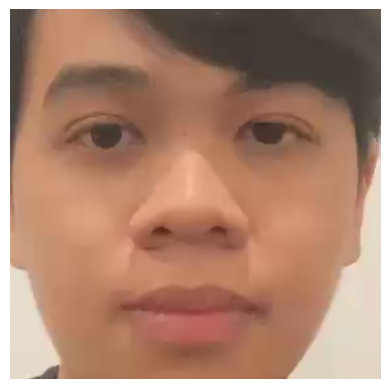

In [7]:
def _extract_face(image, bbox, face_scale_thres = (20, 20)):
  h, w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  # extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]

  # ensure the face width and height are sufficiently large
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None
  else:
    return face

bbox = _extract_bbox(image)
face = _extract_face(image, bbox)
plt.axis("off")
plt.imshow(face)

Tạo vòng lặp trích suất khuông mặt từ các bức ảnh và lưu trữ vào một pickle file. Do giả định mỗi bức ảnh chỉ bao gồm 1 người nên _extract_bbox() được thiết lập single=True.

In [8]:
def _model_processing(face_scale_thres = (20, 20)):
  """
  face_scale_thres: Ngưỡng (W, H) để chấp nhận một khuôn mặt.
  """
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("\\")
    # Lấy nhãn của ảnh
    name = split_img_links[-2] 
    # Đọc ảnh
    image = _image_read(image_link)
    (h, w) = image.shape[:2]
    # Detect vị trí các khuôn mặt trên ảnh. Giả định rằng mỗi bức ảnh chỉ có duy nhất 1 khuôn mặt của chủ nhân classes.
    bbox =_extract_bbox(image, single=True)
    # print(bbox_ratio)
    if bbox is not None:
      # Lấy ra face
      face = _extract_face(image, bbox, face_scale_thres = (20, 20))
      if face is not None:
        faces.append(np.array(face))
        y_labels.append(name)
        images_file.append(image_links)
        total += 1
      else:
        next
  print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

Total bbox face extracted: 223


In [8]:
def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

# _save_pickle(faces, "./faces.pkl")
# _save_pickle(y_labels, "./y_labels.pkl")
# _save_pickle(images_file, "./images_file.pkl")

Dữ liệu ảnh các khuôn mặt hiện tại đang không cùng shape. Do đó cần thực hiện các preprocessing image.

Chúng ta sẽ resize lại các ảnh thông qua hàm resize của opencv.

In [9]:
y_labels = _load_pickle("./y_labels_2.pkl")
faces = _load_pickle("./faces_2.pkl")

faceResizes = []
for face in faces:
  face_rz = cv2.resize(face, (178, 218))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(1400, 218, 178, 3)

Chúng ta sẽ sử dụng pretrain model có tác dụng embedding các khuôn mặt có trong bức ảnh thành những véc tơ embedding 128 chiều. File pretrain chính là nn4.small2.v1.t7

In [10]:
EMBEDDING_FL = "model\openface.nn4.small2.v1.t7"

def _load_torch(model_path_fl):
  model = cv2.dnn.readNetFromTorch(model_path_fl)
  return model


In [11]:
encoder = _load_torch(EMBEDDING_FL)

Ta đã load model encoder. Tiếp theo ta sẽ sử dụng các ảnh khuôn mặt đã được trích xuất để tạo embedding véc tơ. Đầu vào của model sẽ là các ảnh blob kích thước 96x96 nên ta sẽ convert dữ liệu về ảnh blob và sau đó truyền qua encoder.



In [12]:
def _embedding_faces(encoder, faces):
  emb_vecs = []
  for face in faces:
    faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
    # Embedding face
    encoder.setInput(faceBlob)
    vec = encoder.forward()
    emb_vecs.append(vec)
  return emb_vecs

embed_faces = _embedding_faces(encoder, faces)


# Nhớ save embed_faces vào Dataset.
# _save_pickle(embed_faces, "./embed_blob_faces.pkl")

#TRAIN THE MODEL - VGG16


In [18]:
# load model VGG16
based_model = VGG16(weights = 'imagenet',
                    include_top = False, #Ở đây include_top = False để loại bỏ lớp Fully Connected trên cùng.
                    input_shape = (218, 178, 3))

# Freeze layers, not training these layers
for layer in based_model.layers:
    layer.trainable = False 

# Summary model 
based_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

# Xây dựng Mạng MLP (Multi-layer Perceptron) 

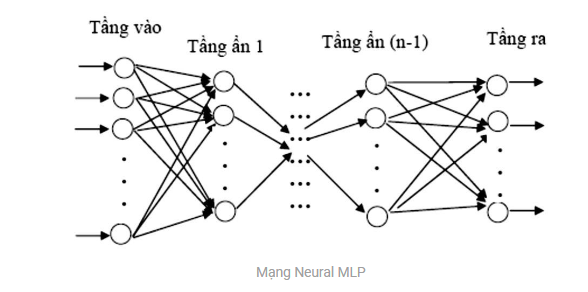

Đầu vào là các vector (x1, x2, …, xp) trong không gian p chiều, đầu ra là các vector (y1, y2, …, yq) trong không gian q chiều. Đối với các bài toán phân loại, p chính là kích thước của mẫu đầu vào, q chính là số lớp cần phân loại.
Mỗi neural thuộc tầng sau liên kết với tất cả các nơron thuộc tầng liền trước nó.
Đầu ra của neural tầng trước là đầu vào của nơron thuộc tầng liền sau nó.
Hoạt động của mạng MLP như sau: tại tầng đầu vào các neural nhận tín hiệu vào xử lý (tính tổng trọng số, gửi tới hàm truyền) rồi cho ra kết quả (là kết quả của hàm truyền); kết quả này sẽ được truyền tới các neural thuộc tầng ẩn thứ nhất; các nơron tại đây tiếp nhận như là tín hiệu đầu vào, xử lý và gửi kết quả đến tầng ẩn thứ 2. Quá trình tiếp tục cho đến khi các neural thuộc tầng ra cho kết quả.

In [21]:
def layer_added(output_based_network, num_classes):
  x = output_based_network
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(num_classes, activation='softmax')(x)

  return x

output_based_network = based_model.output 
output_layer = layer_added(output_based_network, num_classes = len(set(y_labels)))
model = Model(based_model.input, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

# **Phân chia tập train/test**

Để thuận tiện cho so sánh hiệu quả giữa model pretrain và model self-training sẽ phân chia tập dữ liệu thành tập train và test với tỷ lệ 80:20 và so sánh độ chính xác chỉ trên tập test.

In [13]:
embed_faces = _load_pickle("./embed_blob_faces_2.pkl")
y_labels = _load_pickle("./y_labels_2.pkl")

In [14]:
ids = np.arange(len(y_labels))

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(embed_faces), y_labels, ids, test_size = 0.2, stratify = y_labels, random_state=42)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(1120, 128) (280, 128)
1120 280


In [18]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")

In [15]:
id_train = _load_pickle("./id_train_2.pkl")
id_test = _load_pickle("./id_test_2.pkl")

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(1120, 218, 178, 3)
(280, 218, 178, 3)


# Data Augumentation

Thử nghiệm một số phương pháp data augumentation để xem kết quả có cải thiện không.

Tiếp theo ta sẽ khởi tạo một ImageDataGenerator để thực hiện một loạt các bến đổi cho hình ảnh. Trong đó bao gồm:

Chuẩn hóa theo phân phối chuẩn các pixels của ảnh: Trung bình các pixels bằng 0, phương sai bằng 1.

Tạo các ảnh với các góc nghiêng là 20 độ.

Dịch chuyển ảnh theo width, height.

Lật ảnh theo chiều ngang.

Sau khi thực hiện các biến đổi, các biến thể của ảnh sẽ trông như sau:

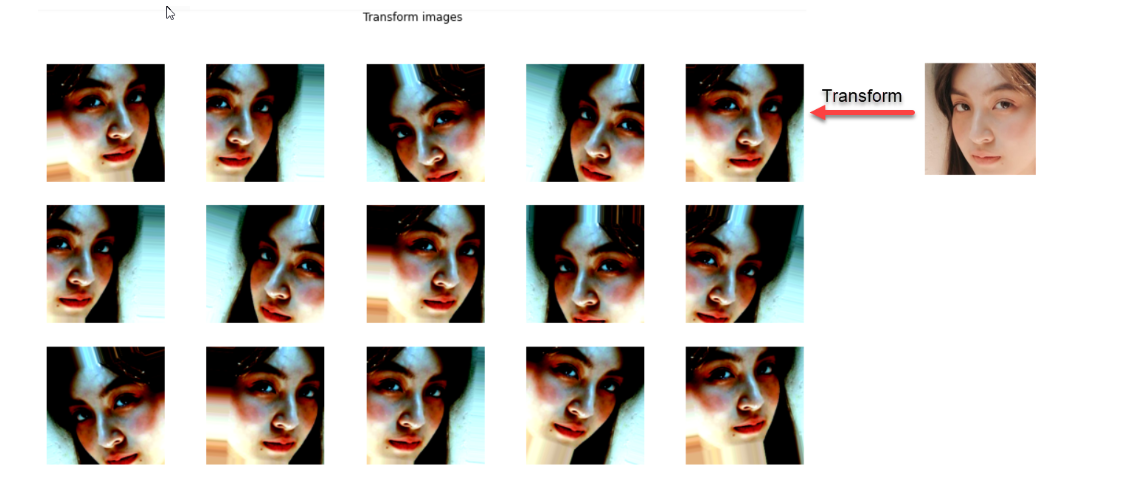

In [20]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [21]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 20:
      break

In [22]:
print(len(X_au))
print(len(y_au))

3560
3560


In [23]:
no_batch = 0
X_test_au = []
y_test_au = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_au.append(x[0])
    y_test_au.append(y_test[i])
    no_img += 1
    if no_img == 20:
      break

In [24]:
#(int(len(y_train)) * 20) // int(len(y_test))

In [25]:
print(len(X_test_au))
print(len(y_test_au))

900
900


# Huấn luyện model


Để huấn luyện model, ta khởi tạo một tensorflow dataset với batch_size = 32 và shuffle sau mỗi 256 steps.

In [26]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['acc'])    

In [27]:
s = list(set(y_au))
s = {s[i]:i for i in range(len(s))}
# y_au_num = []

s_T = {b:a for b,a in enumerate(s)}

y_au_num = [s[y_au[i]] for i in range(len(y_au))] #convert y_au string to num

y_test_au_num = [s[y_test_au[i]] for i in range(len(y_test_au))] #convert y_test_au string to num

In [28]:
gen_train = tf.data.Dataset.from_tensor_slices((X_au,tf.one_hot( y_au_num,23))).shuffle(256).batch(32)
gen_train

gen_val =  tf.data.Dataset.from_tensor_slices((X_test_au,tf.one_hot( y_test_au_num,23))).shuffle(256).batch(32)
gen_val

<BatchDataset element_spec=(TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 23), dtype=tf.float32, name=None))>

In [29]:
# batch_size = 32

# history = model.fit_generator(
#     gen_train,
#     steps_per_epoch = len(X_au)//batch_size,
#     epochs=45,
#     validation_data= gen_val,
#     validation_steps= len(X_test_au)//batch_size,
#     verbose=1)

# best epoch 45 - 50 - loss = 0.072

In [30]:
# tf.config.list_physical_devices('GPU')

In [31]:
#batch_size = 32
# steps_per_epoch= len(X_au)//batch_size
# tf.debugging.set_log_device_placement(True)
# with tf.device('/physical_device:GPU:0'):
history = model.fit(gen_train, validation_data= gen_val, epochs=5)

Epoch 1/5
112/112 [==============================] - 31s 184ms/step - loss: 1.2206 - acc: 0.6910 - val_loss: 1.6290 - val_acc: 0.6156
Epoch 2/5
112/112 [==============================] - 19s 168ms/step - loss: 0.1057 - acc: 0.9685 - val_loss: 1.0854 - val_acc: 0.7256
Epoch 3/5
112/112 [==============================] - 19s 172ms/step - loss: 0.0224 - acc: 0.9958 - val_loss: 0.9279 - val_acc: 0.8000
Epoch 4/5
112/112 [==============================] - 20s 177ms/step - loss: 0.0069 - acc: 0.9992 - val_loss: 0.8483 - val_acc: 0.8356
Epoch 5/5
112/112 [==============================] - 20s 178ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7748 - val_acc: 0.8300


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


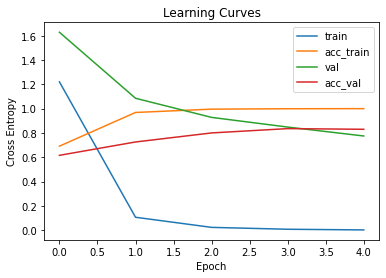

In [32]:
print(history.history.keys())

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['acc'], label='acc_train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.plot(history.history['val_acc'], label='acc_val')
pyplot.legend()
pyplot.show()

In [33]:
model.save("model/model_mlp_au.h5")

In [23]:
from tensorflow import keras
model = keras.models.load_model('model\model_mlp_au_2.h5')

In [24]:
X_train_vec = model.predict(X_train)
X_test_vec = model.predict(X_test)

9/9 [==============================] - 29s 3s/step


# Accuracy trên test
Để dự báo trên tập test thì chúng ta sẽ cần phải transform ảnh trên X theo đúng như nguyên tắc tranform trên tập train.



In [25]:
data_tf = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

In [26]:
def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

In [27]:
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.8571428571428571


# TESTING 

Trước tiên chúng ta cần tạo một hàm normalize để tiền xử lý ảnh trước khi đưa vào dự báo mô hình.

In [28]:
def _normalize_image(image, epsilon=0.000001):
  means = np.mean(image.reshape(-1, 3), axis=0)
  stds = np.std(image.reshape(-1, 3), axis=0)
  image_norm = image - means
  image_norm = image_norm/(stds + epsilon)
  return image_norm

Sau đó ta thực hiện một vòng lặp để trích suất toàn bộ các faces trên ảnh và dự báo kết quả trên từng face.

(603, 1224, 1402, 425)
1/1 [==============================] - 0s 293ms/step
PREDICT NAME:  P.Dang


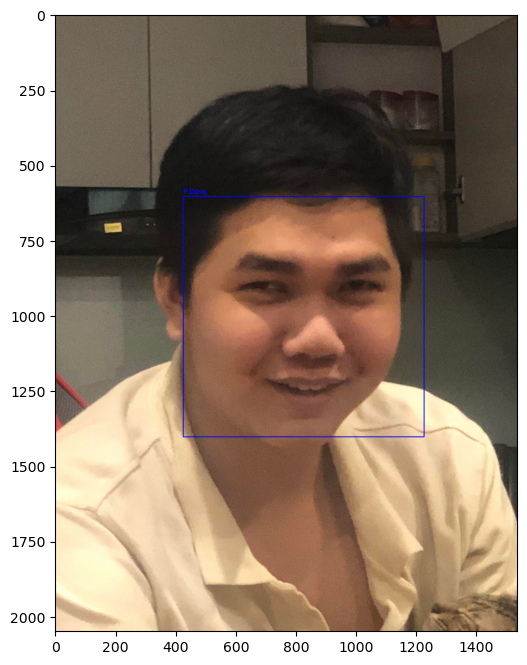

In [29]:
import random 

IMAGE_OUTPUT = "./predictions.jpg"
TEST_PATH = "test"
# IMAGE_PREDICT = random.choice(os.listdir(TEST_PATH))
IMAGE_PREDICT = r"test\test_17.jpg"
# Trích xuất bbox image 
image = _image_read(IMAGE_PREDICT)
# imageBlob = _blobImage(image)
bboxs = _extract_bbox(image, single=False)
# print(len(bboxs))
faces = []
for bbox in bboxs:
  print(bbox)
  face = _extract_face(image, bbox, face_scale_thres = (20, 20))
  
  # face = face.copy()
  faces.append(face)
  try:
    face_rz = cv2.resize(face,  (178, 218))
    # Chuẩn hóa ảnh bằng hàm _normalize_image
    face_tf = _normalize_image(face_rz)
    face_tf = np.expand_dims(face_tf, axis = 0)
    # Embedding face
    vec = model.predict(face_tf)
    # Tìm kiếm ảnh gần nhất
    name = _most_similarity(X_train_vec, vec, y_train)
    acc = accuracy_score(y_preds, y_test)
    # Tìm kiếm các bbox
    (startY, startX, endY, endX) = bbox
    minX, maxX = min(startX, endX), max(startX, endX)
    minY, maxY = min(startY, endY), max(startY, endY)

    text = "{}".format(name)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    image=cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
    image = cv2.putText(image, text, (minX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
  except:
      print("Not found face")
cv2.imwrite(IMAGE_OUTPUT, image)


# import matplotlib.pyplot as plt

plt.figure(figsize = (16, 8))
img = plt.imread(IMAGE_OUTPUT)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("PREDICT NAME: ", name)
plt.imshow(RGB_img)

In [30]:
import cv2
from time import sleep
from imutils.video import VideoStream
import imutils
import time
import cv2

# Set text style
fontface = cv2.FONT_HERSHEY_SIMPLEX
fontscale = 1
fontcolor = (0,255,0)
fontcolor1 = (0,0,255)

In [31]:
# load face detection weights
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load gender detection model 
from tensorflow import keras
model2 = keras.models.load_model('model\model_mlp_au_2.h5')

In [ ]:
# # Predict 
# # Predict 
# def predict(img):
#     r_size = cv2.resize(img,(178,218))
#     roi = cv2.cvtColor(r_size, cv2.COLOR_BGR2RGB)
#     finish = roi.reshape(1,218,178,3)
#     y_pre = model.predict(finish)
#     result = str(name if y_pre > 0.5 else 'Female')
#     print_result = f"Probability: {int(y_pre)} | Gender: {result}"
#     print(print_result)
#     return result

In [ ]:
# face = _extract_face(image, bbox, face_scale_thres = (20, 20))
  
# # face = face.copy()
# faces.append(face)
# try:
#     face_rz = cv2.resize(face,  (178, 218))
#     # Chuẩn hóa ảnh bằng hàm _normalize_image
#     face_tf = _normalize_image(face_rz)
#     face_tf = np.expand_dims(face_tf, axis = 0)
#     # Embedding face
#     vec = model.predict(face_tf)
#     # Tìm kiếm ảnh gần nhất
#     name = _most_similarity(X_train_vec, vec, y_train)
#     acc = accuracy_score(y_preds, y_test)
#     # Tìm kiếm các bbox
#     (startY, startX, endY, endX) = bbox
#     minX, maxX = min(startX, endX), max(startX, endX)
#     minY, maxY = min(startY, endY), max(startY, endY)

#     text = "{}".format(name)
#     y = startY - 10 if startY - 10 > 10 else startY + 10
#     image=cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
#     image = cv2.putText(image, text, (minX, y),
#       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
# except:
#       print("Not found face")

In [34]:
# Read camara
camera = VideoStream(src= r'Video\H.Duc(1).MOV').start()
time.sleep(1.0)

while (True):
    img = camera.read()
    img = imutils.resize(img, width=640, height=480)
    # Flip image
    img = cv2.flip(img, -1)
    faces = face_cascade.detectMultiScale(img, 1.2, 10,minSize=(100,100))

    for (x, y, w, h) in faces:
        try:
            face = img[y:y + h, x:x + w]
            face_rz = cv2.resize(face,  (178, 218))
            face_tf = _normalize_image(face_rz)
            face_tf = np.expand_dims(face_tf, axis = 0)
            vec = model.predict(face_tf)
            name = _most_similarity(X_train_vec, vec, y_train)
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(img, "Name " + name, (x,y+h+30), fontface, fontscale, fontcolor ,2)
        except:
            print("Can't recognize face!")
            
    cv2.imshow("Picture", img)

    # Quit
    key = cv2.waitKey(1)
    if key==ord('q'):
        break

camera.stream.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 248ms/step


In [ ]:
from tensorflow import keras
model2 = keras.models.load_model('model\model_mlp_au.h5')

In [35]:
# Read camara
camera = VideoStream(src= 0).start()
time.sleep(1.0)

while (True):
    img = camera.read()
    img = imutils.resize(img, width=640, height=480)
    # Flip image
    img = cv2.flip(img, 1)
    faces = face_cascade.detectMultiScale(img, 1.2, 10,minSize=(100,100))

    for (x, y, w, h) in faces:
        try:
            face = img[y:y + h, x:x + w]
            face_rz = cv2.resize(face,  (178, 218))
            face_tf = _normalize_image(face_rz)
            face_tf = np.expand_dims(face_tf, axis = 0)
            vec = model2.predict(face_tf)
            name = _most_similarity(X_train_vec, vec, y_train)
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(img, "Name " + name, (x,y+h+30), fontface, fontscale, fontcolor ,2)
        except:
            print("Can't recognize face!")
            
    cv2.imshow("Picture", img)

    # Quit
    key = cv2.waitKey(1)
    if key==ord('q'):
        break

camera.stream.release()
cv2.destroyAllWindows()

# ERROR

Ta sẽ biểu diễn các ảnh bị dự báo sai và xem chúng có đặc điểm gì?

In [ ]:
idx_diff = np.flatnonzero(np.array(y_preds) != np.array(y_test))

fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Wrong predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_test[idx_diff[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')

Tiếp theo ta sẽ xem các ảnh này bị dự báo sai với ảnh nào gần nhất.

In [68]:
def _most_similarity_idx(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1][0]
  # label = [labels[idx] for idx in argmax][0]
  return argmax

# Lấy ra các bức ảnh gần nhất với các ảnh dự báo.
nearest_idx = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  argmax = _most_similarity_idx(X_train_vec, vec, y_train)
  nearest_idx.append(argmax)

# Lọc ra tiếp các ảnh bị dự báo sai.
nearest_idx = [nearest_idx[idx] for idx in idx_diff]

In [ ]:
fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Nearest predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_train[nearest_idx[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')